<h1 align='center' style="color:red"> DeepTweets Challenge </h1>
<h1 align='center' > DOHA BENHABBACH</h1>
<h1 align='center' > TEAM:PGX- DS-T706</h1>
<h1 align='center' > USERNAME:ORCL-DS-APP0706</h1>



### Approach
The task at hand involves assigning labels to new tweets based on a pre-existing dataset of categorized tweets. With only two labels available, the classification is binary. However, it's important to note that some tweets may not fit either category and lead to incorrect classification. To mitigate this, a set of criteria must be established to determine what constitutes a valid tweet, allowing it to be accurately labeled. While each tweet is essentially a string of text, it may possess certain attributes that provide additional context and meaning. Furthermore, the tweet's category, which itself is a property of the tweet, reflects the importance of its attributes.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib as plt
import seaborn as sns
%matplotlib inline

# download stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import matplotlib as plt
import seaborn as sns
%matplotlib inline

### Loading train and test data

In [3]:
# load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [5]:
train_df.describe()

,TweetId
count,6.525000e+03
mean,2.887131e+17
std,5.139819e+16
min,2.390931e+10
25%,2.941380e+17
50%,3.025319e+17
75%,3.053242e+17
max,3.068341e+17


In [6]:
train_df.groupby(['Label']).describe()


TweetId                                                          \
           count          mean           std           min           25%   
Label                                                                      
Politics  3200.0  2.940386e+17  1.414010e+16  2.477269e+17  2.885772e+17   
Sports    3325.0  2.835879e+17  7.027798e+16  2.390931e+10  2.998319e+17   

                                                    
                   50%           75%           max  
Label                                               
Politics  3.005219e+17  3.042852e+17  3.068234e+17  
Sports    3.043017e+17  3.059188e+17  3.068341e+17

In [7]:
train_df["length"] = train_df["TweetText"].apply(len)
train_df.head()

,TweetId,Label,TweetText,length
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...,125
1,304834304222064640,Politics,'@rraina1481 I fear so',23
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...,102
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,121
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...,62


In [8]:
#Null values
train_df.isna().sum()

TweetId      0
Label        0
TweetText    0
length       0
dtype: int64

C:\Users\lenovo\AppData\Local\Temp\ipykernel_2244\1333403575.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df["length"] , bins = 50)


<Axes: xlabel='length', ylabel='Density'>

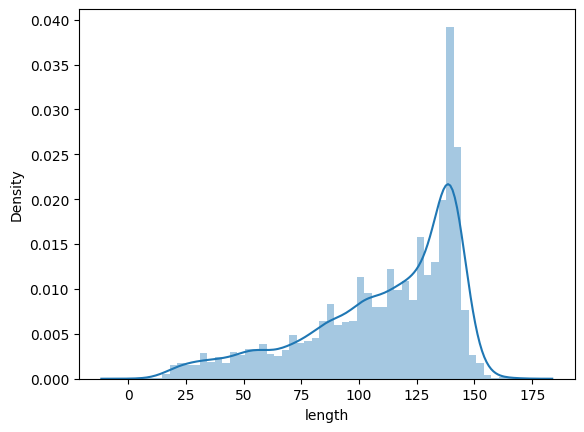

In [9]:
# create a distribution plot (histogram) of the length column in the train_df DataFrame using the Seaborn library (sns).
sns.distplot(train_df["length"] , bins = 50)

In [10]:
import seaborn as sns


In [11]:
train_df["length"].describe()

count    6525.000000
mean      110.346820
std        32.234194
min         5.000000
25%        91.000000
50%       119.000000
75%       138.000000
max       167.000000
Name: length, dtype: float64

array([<Axes: title={'center': 'Politics'}>,
       <Axes: title={'center': 'Sports'}>], dtype=object)

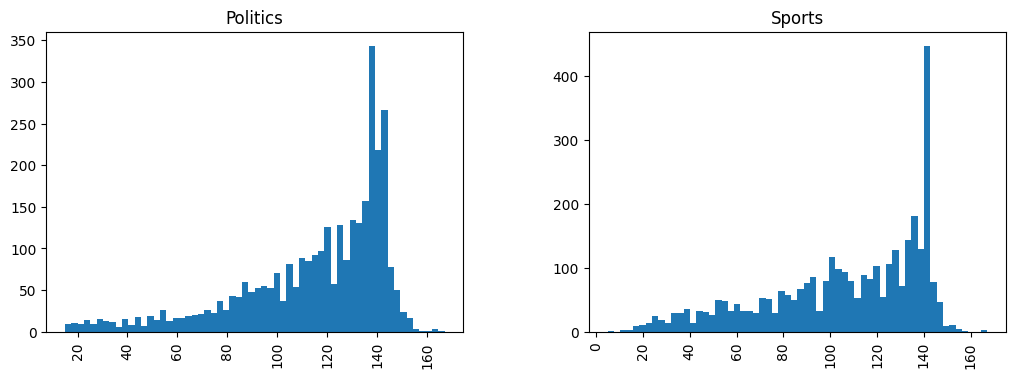

In [12]:
train_df.hist(column="length" , by="Label", bins = 60 ,figsize= (12,4))

# Text Preprocessing

Text preprocessing refers to the process of cleaning and transforming raw text data into a format that can be easily analyzed by machine learning algorithms. This process involves a series of steps, including:


1-Tokenization: splitting the text into individual words, also known as tokens.
Stop word removal: removing common words that do not add meaning to the text, such as "the", "and", and "is". 

2-Stemming or lemmatization: reducing each word to its base or root form, so that similar words are treated the same way, for example, "running", "runs", and "ran" would all be reduced to "run". 

3-Vectorization: converting text into a numerical representation, such as a bag-of-words or TF-IDF representation.

In [36]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

def preprocess(text):
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # tokenize using custom regular expression to preserve words with numeric characters
    tokenizer = RegexpTokenizer(r'\b(?:\d+\w+|\w+\d+|\w+)\b')
    tokens = tokenizer.tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # stem
    stemmer = nltk.PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # remove numeric characters
    tokens = [re.sub(r'\d', '', token) for token in tokens]

    # join tokens back into a string
    text = ' '.join(tokens)

    return text


In [51]:
# preprocess the tweet text
train_df['TweetText'] = train_df['TweetText'].apply(preprocess)
test_df['TweetText'] = test_df['TweetText'].apply(preprocess)


In [52]:
train_df

,TweetId,Label,TweetText,length
0,304271250237304833,Politics,seckerri valu statedept usaid measur dollar te...,125
1,304834304222064640,Politics,rraina fear,23
2,303568995880144898,Sports,watch video highlight wwc final australia west...,102
3,304366580664528896,Sports,rt chelscanlan nitro circu albertpark theymake...,121
4,296770931098009601,Sports,cricketfox alway good thing thank feedback,62
...,...,...,...,...
6520,296675082267410433,Politics,photo pm laid wreath martyr monument algier ht...,102
6521,306677536195231746,Sports,secret chennai pitch crumbl edg solid middl li...,128
6522,306451295307431937,Sports,alinabhutto isnt twitter either,39
6523,306088574221176832,Sports,england player would take dinner featur lukewr...,142


In [53]:
test_df

,TweetId,TweetText
0,306486520121012224,home side threaten mason bennett get end long ...
1,286353402605228032,mrbrown aulia thx ask see httptcoygjepjkf deri...
2,289531046037438464,sochi construct along shore black sea httptcod...
3,306451661403062273,seckerryu remark meet foreign minist westerwel...
4,297941800658812928,iplauct begun ricki pont first player go hamme...
...,...,...
2605,282023761044189184,qualifi elimin game play chidambaram stadium u...
2606,303879735006601216,reesedward hi edward peacekeep mission guineab...
2607,297956846046703616,perera sunrisersipl first ipl purcha iplauct
2608,304265049537658880,seckerri thank senat timkain reproberthurt uva...


In [54]:

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df['TweetText'], train_df['Label'], test_size=0.2, random_state=42)


# Feature Extraction

Feature extraction involves transforming text data into a numerical representation that can be understood by machine learning algorithms. This can include techniques such as bag-of-words, term frequency-inverse document frequency (TF-IDF), and word embeddings.

The goal of feature extraction is to identify the most relevant features of the data that will help the machine learning model to make accurate predictions. By reducing the dimensionality of the input data and focusing on the most important features, the model can be more efficient and effective in its predictions.

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ ####
   <h5 align='center'>In this process we need to  : </h5>

-Create a TfidfVectorizer object with specified parameters  

-Fit the vectorizer on the training data and transform it  

-Transform the validation and test data using the fitted vectorizer

In [55]:
# create a TfidfVectorizer object with specified parameters
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)

# fit the vectorizer on the training data and transform it
X_train1 = vectorizer.fit_transform(train_df['TweetText'])

# transform the validation and test data using the fitted vectorizer
X_val1 = vectorizer.transform(X_val)
X_test1 = vectorizer.transform(test_df['TweetText'])

# Model Training and Hyperparameter Tuning:

This process is very important , is consiste to create a model that learns from the data to generate predictions 
1- Create a pipeline for vecoriztion and classification

In [56]:
# create a pipeline for vectorization and classification
pipeline = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 3), max_features=10000)),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('chi', SelectKBest(chi2, k=5000)),
    ('clf', VotingClassifier([
        ('nb', MultinomialNB(alpha=0.1)),
        ('lr', LogisticRegression(C=10, max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42)),
        ('svm', SVC(C=1, kernel='linear', probability=True, random_state=42))
    ]))
])


In [57]:
# fit the pipeline on the training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('chi',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x0000020D0AE12440>)),
                ('clf',
                 VotingClassifier(estimators=[('nb', MultinomialNB(alpha=0.1)),
                                              ('lr',
                                               LogisticRegression(C=10,
                                                                  max_iter=1000,
                                                                  random_state=42)),
                                              ('rf',
                                               RandomForestClassifier(max_depth=5,
                                                                      n_estimators=500,
                                                                      random_state=42)),
                                              ('svm',
                                               SVC(C=1, kernel='linear',
                                                   probability=True,
                                                   random_state=42))]))])

In [58]:
# make predictions on the validation set and calculate accuracy
y_pred = pipeline.predict(X_val)
#Performance evaluation:
acc = accuracy_score(y_val, y_pred)
print('Validation accuracy:', acc)

Validation accuracy: 0.9517241379310345


In [59]:
# make predictions on the test data
test_pred = pipeline.predict(test_df['TweetText'])

In [60]:
# create submission file
submission_df = pd.DataFrame({'TweetId': test_df['TweetId'], 'Label': test_pred})
submission_df.to_csv('submission1.csv', index=False)
